# Generating Songs Using an LSTM from Genius Lyrics
Data collection info here ---> https://github.com/johnwmillr/LyricsGenius

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import json
from torch.utils.data.sampler import SubsetRandomSampler
from torch import optim
from LSTM import *

# Check if your system supports CUDA
torch.manual_seed(42069)
np.random.seed(42069)
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

CUDA is supported


In [2]:
dataset = loader('Lyrics_Pitbull.json', with_tags=True)
batch_size = 1

In [3]:
print(dataset.songs[1])

<start>
Title: Options
[Intro: Pitbull]
Stephen Marley, let 'em know what time it is

[Verse 1: Stephen Marley]
We came here to party, we came here to dance
You know that you're my girl, damn right I'm your man
This night going too good, don't fall for the games
Or the he said, she said dumb shit

[Pre-Chorus: Stephen Marley]
I got a whole lot of names and a whole lot of numbers
But I'll throw them away 'cause I think I might love you
Could be the Mary Jane or the spell that I'm under
But I know what this could be
Tearing up my history for you

[Chorus: Stephen Marley]
I got, I got, I got, I got options
You the, you the, you the, you the top one
So baby, baby, if it ain't a problem
Can I get some of your love?
I got, I got, I got, I got options
You the, you the, you the, you the top one
So baby, baby, if it ain't a problem
Can I get some of your love?

[Verse 2: Pitbull]
Been around the game, been around the fame
Been around the money, been around some names
But the chico's still the s

# Train Validation Splits

In [4]:
validation_split = .3
shuffle_dataset = True

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(42069)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

# LSTM Architecture

In [5]:
input_dim = len(dataset.char_dict)
hidden_dim = 300
n_layers = 3
batch_size = 1

model = Nnet(input_dim, hidden_dim, n_layers, dropout=0.25)
model.to(device)

Nnet(
  (lstm_layer): LSTM(124, 300, num_layers=3, dropout=0.25)
  (fc): Linear(in_features=300, out_features=124, bias=True)
)

# Loss Functions and Optimizer

In [6]:
#loss criteria are defined in the torch.nn package
criterion = nn.CrossEntropyLoss()

#Instantiate the gradient descent optimizer - use Adam optimizer with default parameters
optimizer = optim.Adam(model.parameters(), lr = 0.0001, amsgrad=True)

# Training Process

In [7]:
epochs = 200
clip = 10
chunk_len = 100
early_stop = True
early_stop_thresh = 15
valid_loss_min = np.Inf

val_losses_epoch = []
train_losses_epoch = []

def get_labels(inputs):
    labels = torch.zeros(inputs.shape[0])

    for i,oneHot in enumerate(inputs[1:]):
        idx = oneHot.argmax().item()
        labels[i] = idx
        
    return labels


index_to_char = {v: k for k, v in dataset.char_dict.items()}

model.train()
print("Training...")
for epoch in range(epochs):
    # training process
    for sample_idx, song in enumerate(train_loader):
        h = model.init_hidden(batch_size)
        song_chunks = chunkstring(song[0], chunk_len)
        for chunk in song_chunks:
            inputs = encode_chunk(chunk, dataset.char_dict)
            labels = get_labels(inputs)
            h = tuple([e.data for e in h])
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            model.zero_grad()
            output, h = model(inputs, h)
            loss = criterion(output, labels)
            h = tuple([e.detach() for e in h])
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
        
        
    # validation process
    val_losses = []
    model.eval()
    #print("Evaluating on validation set...")
    for sample_idx, song in enumerate(val_loader):
#         if sample_idx % 100 == 0:
#             print("Evaluating on song %d (%d/%d)"  % (sample_idx, sample_idx, len(val_loader)))
        val_h = model.init_hidden(batch_size)
        val_h = tuple([each.data for each in val_h])
        song_chunks = chunkstring(song[0], chunk_len)
        
        for chunk in song_chunks:
            inputs = encode_chunk(chunk, dataset.char_dict)
            labels = get_labels(inputs)
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            output, val_h = model(inputs, val_h)
            val_loss = criterion(output, labels)
            val_losses.append(val_loss.item())
        
    # evaluate on the training set to get training loss metrics
    train_losses = []
    #print("Evaluting on training set...")
    for sample_idx, song in enumerate(train_loader):
        h = model.init_hidden(batch_size)
        song_chunks = chunkstring(song[0], chunk_len)
        for chunk in song_chunks:
            inputs = encode_chunk(chunk, dataset.char_dict)
            labels = get_labels(inputs)
            h = tuple([e.data for e in h])
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            output, h = model(inputs, h)
            train_loss = criterion(output, labels)
            train_losses.append(train_loss.item())
    
    
    train_losses_epoch.append(np.mean(train_losses))
    val_losses_epoch.append(np.mean(val_losses))

    model.train()
    print("Epoch: {}/{}...".format(epoch+1, epochs),
          "Training Loss: {:.6f}...".format(np.mean(train_losses)),
          "Validation Loss: {:.6f}".format(np.mean(val_losses)))
    
    if epoch % 5 == 0:
        print('Creating training checkpoint...')
        # save training progress every five epochs
        state = {
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(state, 'pitbull_state_ckpt.pth')
    
    if val_losses_epoch[epoch] <= valid_loss_min:
        torch.save(model.state_dict(), './pitbull_state_dict.pth')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
        valid_loss_min = np.mean(val_losses)
        
        if early_stop:
            early_stop_strikes = 0
    
    else:
        if early_stop:
            early_stop_strikes += 1
            if early_stop_strikes >= early_stop_thresh:
                print("Early stopping is enabled. Training will now stop.")
                break
            else:
                print("Early stopping is enabled. Training will stop in %d epochs if validation loss does not go down."
                    % (early_stop_thresh-early_stop_strikes))

Training...
Epoch: 1/200... Training Loss: 2.798669... Validation Loss: 2.811959
Creating training checkpoint...
Validation loss decreased (inf --> 2.811959).  Saving model ...
Epoch: 2/200... Training Loss: 2.469244... Validation Loss: 2.485526
Validation loss decreased (2.811959 --> 2.485526).  Saving model ...
Epoch: 3/200... Training Loss: 2.276185... Validation Loss: 2.301310
Validation loss decreased (2.485526 --> 2.301310).  Saving model ...
Epoch: 4/200... Training Loss: 2.119569... Validation Loss: 2.168605
Validation loss decreased (2.301310 --> 2.168605).  Saving model ...
Epoch: 5/200... Training Loss: 2.005327... Validation Loss: 2.076552
Validation loss decreased (2.168605 --> 2.076552).  Saving model ...
Epoch: 6/200... Training Loss: 1.902217... Validation Loss: 1.991838
Creating training checkpoint...
Validation loss decreased (2.076552 --> 1.991838).  Saving model ...
Epoch: 7/200... Training Loss: 1.837416... Validation Loss: 1.943580
Validation loss decreased (1.991

Epoch: 54/200... Training Loss: 0.629115... Validation Loss: 1.468554
Early stopping is enabled. Training will stop in 1 epochs if validation loss does not go down.
Epoch: 55/200... Training Loss: 0.615806... Validation Loss: 1.477159
Early stopping is enabled. Training will now stop.


# Loss Curves

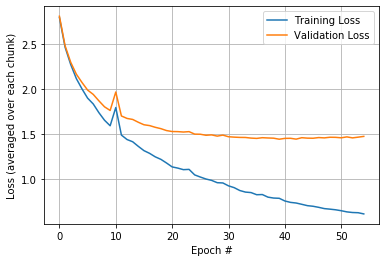

In [8]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.plot(train_losses_epoch)
plt.plot(val_losses_epoch)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch #')
plt.grid()
plt.ylabel('Loss (averaged over each chunk)')
plt.show()

# Generating Lyrics

In [9]:
from torch.nn.functional import softmax
from torch.distributions.categorical import Categorical
from copy import deepcopy


model = Nnet(input_dim, hidden_dim, n_layers, dropout=0.25)
model.load_state_dict(torch.load('pitbull_state_dict.pth'))
model.to(device)
model.eval()


def get_next_char(model, char_dict, hidden, input_token='<start>', sampling_scheme='softmax', temperature=0.7):
    '''Gets the next character given a chunk input_token
    :param: a pytorch neural network to be passed
    :char_dict: a dictionary mapping alphanumeric characters of type str to integers
    :input_token: the string to begin on for the LSTM
    '''
    inputs = encode_chunk(input_token, char_dict)
    h = tuple([e.data for e in hidden])
    inputs = inputs.to(device)

    output, h = model(inputs, h)

    if sampling_scheme == 'softmax':
        prediction_vector = softmax(output / temperature, dim=1)
        output_dist = Categorical(probs=prediction_vector)
        next_char = output_dist.sample()[-1]
    else:
        # argmax sampling scheme
        prediction_vector = softmax(output, dim=1)
        next_char = prediction_vector.argmax(dim=1)[-1]
    
    return next_char, h

In [10]:
generated_file_size = 100000 # characters
model_name = 'Pitbull_LSTM'

next_chunk = '<start>\nTitle:'

out = deepcopy(next_chunk)
    
index_to_char = {v: k for k, v in dataset.char_dict.items()}

max_chunk_size = 300
#try passing in the token with 0'd hidden units at the beginning then take the hidden unit output
#from that and pass that back in with the token again and go on from there
hidden = model.init_hidden(1)
for progress,i in enumerate(range(generated_file_size)):
    if progress % 500 == 0:
        print("Generation progress: %d/%d characters" % (progress, generated_file_size))
    if progress == 0 or next_chunk[-len('<end>'):] == '<end>':
        if progress > 0:
            next_chunk = '<start>\n'
            out += '\n<start>\n'
        #hidden = model.init_hidden(1)
    
    (next_char, h) = get_next_char(model, dataset.char_dict, hidden, input_token=next_chunk)
    char = index_to_char[next_char.item()]
    
    if len(next_chunk) < max_chunk_size:
        next_chunk += char
    else:
        next_chunk = next_chunk[1:] + char
    out += char
    
with open("generated_songs/generated_songs_" + model_name + ".txt", "w") as text_file:
    print(out, file=text_file)
    
print(out)

Generation progress: 0/100000 characters
Generation progress: 500/100000 characters
Generation progress: 1000/100000 characters
Generation progress: 1500/100000 characters
Generation progress: 2000/100000 characters
Generation progress: 2500/100000 characters
Generation progress: 3000/100000 characters
Generation progress: 3500/100000 characters
Generation progress: 4000/100000 characters
Generation progress: 4500/100000 characters
Generation progress: 5000/100000 characters
Generation progress: 5500/100000 characters
Generation progress: 6000/100000 characters
Generation progress: 6500/100000 characters
Generation progress: 7000/100000 characters
Generation progress: 7500/100000 characters
Generation progress: 8000/100000 characters
Generation progress: 8500/100000 characters
Generation progress: 9000/100000 characters
Generation progress: 9500/100000 characters
Generation progress: 10000/100000 characters
Generation progress: 10500/100000 characters
Generation progress: 11000/100000 

Generation progress: 91500/100000 characters
Generation progress: 92000/100000 characters
Generation progress: 92500/100000 characters
Generation progress: 93000/100000 characters
Generation progress: 93500/100000 characters
Generation progress: 94000/100000 characters
Generation progress: 94500/100000 characters
Generation progress: 95000/100000 characters
Generation progress: 95500/100000 characters
Generation progress: 96000/100000 characters
Generation progress: 96500/100000 characters
Generation progress: 97000/100000 characters
Generation progress: 97500/100000 characters
Generation progress: 98000/100000 characters
Generation progress: 98500/100000 characters
Generation progress: 99000/100000 characters
Generation progress: 99500/100000 characters
<start>
Title: Drick Vors
[Intro: Pitbull]
Mestericants not in stertenderntand
I'm straight to be free
But I'm a not worldwide
It's all I want
Cause I don't want a hot
I got the Yangath
Like Bonnin' they chicos up you looking or the ro